# install


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Fri Nov 18 11:17:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

In [ ]:
!pip install transformers==4.12.2
!pip install farasapy==0.0.14
!pip install pyarabic==0.6.14
!git clone https://github.com/aub-mind/arabert
!pip install emoji==1.6.1
!pip install sentencepiece==0.1.96

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 31.0 MB/s 
     |████████████████████████████████| 182 kB 64.4 MB/s 
     |████████████████████████████████| 3.3 MB 61.9 MB/s 
     |████████████████████████████████| 880 kB 44.4 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=eee747d3a057a374f62e56b3b3baa6a22cd36f9c021041fc90bd8b54e4e117da
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 28.2 MB/s 
Cloning into 'arabert'...
remote: Enumerating objects: 600, done.
remote: Counting objects: 100% (65/65), done.
remo

In [ ]:
import pandas as pd
import numpy as np
from typing import List
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

# dataset

In [ ]:
class CustomDataset:
    def __init__(
        self,
        name: str,
        train: List[pd.DataFrame],
        test: List[pd.DataFrame],
        label_list: List[str],
    ):
        """Class to hold and structure datasets.

        Args:

        name (str): holds the name of the dataset so we can select it later
        train (List[pd.DataFrame]): holds training pandas dataframe with 2 columns ["text","label"]
        test (List[pd.DataFrame]): holds testing pandas dataframe with 2 columns ["text","label"]
        label_list (List[str]): holds the list  of labels
        """
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [ ]:
# This will hold all the downloaded and structred datasets
all_datasets= []
DATA_COLUMN = "text"
LABEL_COLUMN = "label"

In [ ]:
ailments_data = pd.read_excel('ailments_arabic.xlsx',header = None)
ailments_data.rename(columns = {0:'phrase', 1:'prompt'}, inplace = True)


ailments_data.columns = [DATA_COLUMN, LABEL_COLUMN]
print(ailments_data[LABEL_COLUMN].value_counts())

label_list = list(ailments_data[LABEL_COLUMN].unique())

ailments_data[LABEL_COLUMN] = ailments_data[LABEL_COLUMN].astype('category')

ailments_data[LABEL_COLUMN] = ailments_data[LABEL_COLUMN].cat.codes
ailments_data


train, test = train_test_split(ailments_data, test_size=0.2, random_state=42)


data = CustomDataset("ailments_data", train, test, label_list)
# # all_datasets.append(data_Hard)

Flu           31
Anemia        28
Stress        23
Allergy       21
Fatigue       20
Bronchitis    17
Diarrhea      12
Name: label, dtype: int64


# train

In [ ]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import copy

from arabert.preprocess import ArabertPreprocessor
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer, Trainer,
                          TrainingArguments)
from transformers.data.processors.utils import InputFeatures

In [ ]:

# select a model from the huggingface modelhub https://huggingface.co/models?language=ar
model_name = 'Ammar-alhaj-ali/arabic-MARBERT-dialect-identification-city' # we are going to use the twitter AraBERT since it has emojis and dialects

In [ ]:
arabic_prep = ArabertPreprocessor(model_name)

data.train[DATA_COLUMN] = data.train[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))
data.test[DATA_COLUMN] = data.test[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))  

In [ ]:
list(data.train[DATA_COLUMN][0:10])

['لدي الأظافر البيضاء',
 'لدي الصداع ، والدوخة ، وطنين في الأذنين',
 'أنا لا أستطيع التنفس',
 'لدي بشرة الجافة جدا',
 'لدي طفح جلدي',
 'لدي العرق البارد',
 'لدي صداع',
 'أسعل',
 'أنا جائع جدا ولكن ليس لدي شهية',
 'أريد أن أنام ، أنا نعسان']

In [ ]:
tok = AutoTokenizer.from_pretrained(model_name)

loading file https://huggingface.co/Ammar-alhaj-ali/arabic-MARBERT-dialect-identification-city/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/69290462745b1865dac00fbd2b0279a10cba09c40f032fc91e779b222fe7fe97.9985cd6ca030442c4f68221160381b229fee63902f75a8f43e14e78007536585
loading file https://huggingface.co/Ammar-alhaj-ali/arabic-MARBERT-dialect-identification-city/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/e8a327f7653443a2e68232e7ace452fcbc0b32feca96916c7417fc10ec187de8.c45a0acbaab52f14cb775dbc8f96269b8448af78e79b7ffe7ea1aee9af1c3d30
loading file https://huggingface.co/Ammar-alhaj-ali/arabic-MARBERT-dialect-identification-city/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/Ammar-alhaj-ali/arabic-MARBERT-dialect-identification-city/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/12738ae0a8fd10ad2711e0257b3a28e75a7d1101fc188c285891f543ea53eb9d.7

Training Sentence Lengths: 


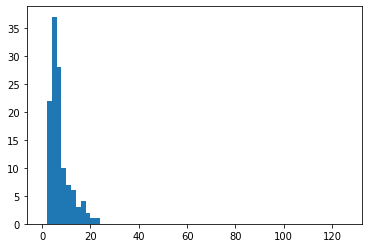

Testing Sentence Lengths: 


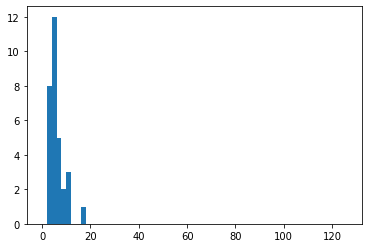

In [ ]:
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in data.train[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in data.test[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

In [ ]:
max([ len(tok.tokenize(sentence)) for sentence in data.test[DATA_COLUMN].to_list()])
max([ len(tok.tokenize(sentence)) for sentence in data.train[DATA_COLUMN].to_list()])

max_len=25

In [ ]:
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in data.train[DATA_COLUMN].to_list()]))

print("Truncated testing sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in data.test[DATA_COLUMN].to_list()]))

Truncated training sequences:  0
Truncated testing sequences:  0


In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(ClassificationDataset).__init__()
      """
      Args:
      text (List[str]): List of the training text
      target (List[str]): List of the training labels
      tokenizer_name (str): The tokenizer name (same as model_name).
      max_len (int): Maximum sentence length
      label_map (Dict[str,int]): A dictionary that maps the class labels to integer
      """
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map
      

    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())
        
      inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
      )      
      return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [ ]:
label_map = { v:index for index, v in enumerate(data.label_list) }
print(label_map)

train_dataset = ClassificationDataset(
    data.train[DATA_COLUMN].to_list(),
    data.train[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )
test_dataset = ClassificationDataset(
    data.test[DATA_COLUMN].to_list(),
    data.test[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )

{'Allergy': 0, 'Anemia': 1, 'Bronchitis': 2, 'Diarrhea': 3, 'Fatigue': 4, 'Flu': 5, 'Stress': 6}


loading file https://huggingface.co/Ammar-alhaj-ali/arabic-MARBERT-dialect-identification-city/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/69290462745b1865dac00fbd2b0279a10cba09c40f032fc91e779b222fe7fe97.9985cd6ca030442c4f68221160381b229fee63902f75a8f43e14e78007536585
loading file https://huggingface.co/Ammar-alhaj-ali/arabic-MARBERT-dialect-identification-city/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/e8a327f7653443a2e68232e7ace452fcbc0b32feca96916c7417fc10ec187de8.c45a0acbaab52f14cb775dbc8f96269b8448af78e79b7ffe7ea1aee9af1c3d30
loading file https://huggingface.co/Ammar-alhaj-ali/arabic-MARBERT-dialect-identification-city/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/Ammar-alhaj-ali/arabic-MARBERT-dialect-identification-city/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/12738ae0a8fd10ad2711e0257b3a28e75a7d1101fc188c285891f543ea53eb9d.7

In [ ]:
print(next(iter(train_dataset)))

KeyError: ignored

In [ ]:
len(label_map)

7

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

In [ ]:
def compute_metrics(p): #p should be of type EvalPrediction
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)
  #print(classification_report(p.label_ids,preds))
  #print(confusion_matrix(p.label_ids,preds))
  macro_f1 = f1_score(p.label_ids,preds,average='macro')
  #macro_precision = precision_score(p.label_ids,preds,average='macro')
  #macro_recall = recall_score(p.label_ids,preds,average='macro')
  acc = accuracy_score(p.label_ids,preds)
  return {       
      'macro_f1' : macro_f1,
      'accuracy': acc
  }

In [ ]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark = False

In [ ]:
training_args = TrainingArguments( 
    output_dir= "./train",    
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 16, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 2,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 25
  )

set_seed(training_args.seed)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

loading configuration file https://huggingface.co/Ammar-alhaj-ali/arabic-MARBERT-dialect-identification-city/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/91e8d6169e360dbb82e1011844a0a4e328c9a371275c4145f4ff7154613af8ac.337289b35831d3b14be2112c7bbcc35339dc0f4265ff61051cf4098d1711d799
Model config BertConfig {
  "_name_or_path": "UBC-NLP/MARBERT",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LAB

RuntimeError: ignored

In [ ]:
#start the training
trainer.train()

In [ ]:
model_init()

loading configuration file https://huggingface.co/Ammar-alhaj-ali/arabic-MARBERT-dialect-identification-city/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/91e8d6169e360dbb82e1011844a0a4e328c9a371275c4145f4ff7154613af8ac.337289b35831d3b14be2112c7bbcc35339dc0f4265ff61051cf4098d1711d799
Model config BertConfig {
  "_name_or_path": "UBC-NLP/MARBERT",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LAB

RuntimeError: ignored